In [1]:
# Cell 1: Keep-alive + installs (run once — prevents disconnects)
from IPython.display import display, Javascript
display(Javascript('''
function ClickConnect(){
  console.log("Keeping alive");
  document.querySelector("colab-connect-button")?.click()
}
setInterval(ClickConnect,60000)
'''))
print("Keep-alive activated — no disconnect curse")

!pip install torch matplotlib numpy pandas

# Cell 2: The sim code (optimized — real Curiosity data + synthetic wind + visualization)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.amp
from torch.utils.checkpoint import checkpoint
import pandas as pd
import numpy as np
from contextlib import nullcontext
import math
import os
import matplotlib.pyplot as plt

torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# CONFIG – optimized for speed + stability
triality = 3
dim = 384
latent_dim = 8
seq_len = 512
batch_size = 64
epochs = 3000  # reduced for fast run (sigma trend visible early)
lr = 5e-5
use_amp = True
use_checkpoint = True

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "mars_weather_checkpoint.pth")

# Real Curiosity Mars weather data (temperature + pressure) + synthetic wind
curiosity_url = "https://raw.githubusercontent.com/the-pudding/data/master/mars-weather/mars-weather.csv"
df = pd.read_csv(curiosity_url)

# Select features (temp + pressure)
df = df[['min_temp', 'max_temp', 'pressure']].dropna()

# Normalize
data_np = df.values.astype(np.float32)
data_np = (data_np - data_np.mean(axis=0)) / (data_np.std(axis=0) + 1e-8)

# Add synthetic wind speed (correlated for coherence)
t = np.linspace(0, 10*math.pi, len(data_np))
wind = np.sin(t * 1.3) * 0.3 + np.random.randn(len(data_np)) * 0.1
wind = wind[:, np.newaxis]
data_np = np.concatenate([data_np, wind], axis=1)  # add wind column

# Resample to seq_len batches
num_samples = len(data_np) // seq_len * seq_len
data_np = data_np[:num_samples]
data_tensor = torch.tensor(data_np).view(-1, seq_len, data_np.shape[1]).float().to(device)

# Batch
batch_size = min(batch_size, data_tensor.shape[0])
data_tensor = data_tensor[:batch_size * (data_tensor.shape[0] // batch_size)]
mars_weather = data_tensor.to(device)

# Project to shared dim
proj = nn.Linear(data_np.shape[1], dim).to(device)
clean_data = proj(mars_weather)

# High masking (70–90% — sensor dropout/dust storms proxy)
missing_rate = torch.linspace(0.7, 0.9, batch_size, device=device).view(batch_size, 1, 1)
mask = torch.rand_like(clean_data) < missing_rate
real_data = clean_data.clone()
real_data[mask] = 0

target = clean_data

# E8 roots – precompute
def get_e8_roots():
    roots = []
    for i in range(8):
        for j in range(i+1, 8):
            for signs in [(1,1), (1,-1), (-1,1), (-1,-1)]:
                v = torch.zeros(8)
                v[i] = signs[0]; v[j] = signs[1]
                roots.append(v); roots.append(-v)
    for signs in range(1 << 8):
        v = torch.tensor([(1 if (signs & (1<<k)) else -1) for k in range(8)], dtype=torch.float32) * 0.5
        if bin(signs).count('1') % 2 == 0:
            roots.append(v); roots.append(-v)
    roots = torch.stack(roots[:240])
    return roots / roots.norm(dim=-1, keepdim=True)

e8_roots = get_e8_roots().to(device)

# Triality Cycle Block
class MarsCycleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Linear(latent_dim, dim // triality, bias=False)
        self.register_buffer('roots', e8_roots)

    def forward(self, x, step):
        pos_emb = self.roots[torch.arange(x.shape[1], device=device) % 240]
        low_dim = self.proj(pos_emb)
        emb = low_dim.repeat(1, triality)
        with torch.no_grad():
            pump_scalar = 0.8 * math.sin(step * 0.006 * 2 * math.pi)
        pump = torch.full((1, x.shape[1], 1), pump_scalar, device=device)
        emb_broadcast = emb.unsqueeze(0)
        x_rot1 = x * (emb_broadcast.cos() + pump)
        x_rot2 = torch.roll(x_rot1, shifts=1, dims=1) * emb_broadcast.sin()
        x_rot3 = torch.roll(x_rot2, shifts=1, dims=1) * emb_broadcast.cos()
        fused = (x_rot1 + x_rot2 + x_rot3) / triality
        return fused

# Dummy cycle for ablation
class DummyCycle(nn.Module):
    def forward(self, x, step=None):
        return x

# Model with ablation support
class E8MarsFusion(nn.Module):
    def __init__(self, depth=32, use_triality=True):
        super().__init__()
        self.use_triality = use_triality
        self.cycle = MarsCycleBlock() if use_triality else DummyCycle()
        self.layers = nn.ModuleList([nn.MultiheadAttention(dim, triality if use_triality else 8, batch_first=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, dim)

    def forward(self, x, step):
        x = self.cycle(x, step)
        for layer in self.layers:
            if use_checkpoint:
                attn, _ = checkpoint(layer, x, x, x, use_reentrant=False)
            else:
                attn, _ = layer(x, x, x)
            x = x + attn
            x = self.norm(x)
        return x

# Models
model = E8MarsFusion(use_triality=True).to(device)
model_ablation = E8MarsFusion(use_triality=False).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

opt_ablation = torch.optim.AdamW(model_ablation.parameters(), lr=lr)
scaler_ablation = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

loss_fn = nn.MSELoss()

loss_hist = []
loss_abl_hist = []

start_epoch = 0

# Load checkpoint if exists
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model'])
    model_ablation.load_state_dict(checkpoint['model_ablation'])
    opt.load_state_dict(checkpoint['opt'])
    opt_ablation.load_state_dict(checkpoint['opt_ablation'])
    scaler.load_state_dict(checkpoint['scaler'])
    scaler_ablation.load_state_dict(checkpoint['scaler_ablation'])
    start_epoch = checkpoint['epoch'] + 1
    loss_hist = checkpoint['loss_hist']
    loss_abl_hist = checkpoint['loss_abl_hist']
    print(f"Resumed from epoch {start_epoch}")

for epoch in range(start_epoch, epochs):
    opt.zero_grad(set_to_none=True)
    opt_ablation.zero_grad(set_to_none=True)

    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon = model(real_data, epoch)
        loss = loss_fn(recon, target)

        recon_abl = model_ablation(real_data, epoch)
        loss_abl = loss_fn(recon_abl, target)

    scaler.scale(loss).backward() if use_amp else loss.backward()
    scaler.unscale_(opt) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
    scaler.step(opt) if use_amp else opt.step()
    scaler.update() if use_amp else None

    scaler_ablation.scale(loss_abl).backward() if use_amp else loss_abl.backward()
    scaler_ablation.unscale_(opt_ablation) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model_ablation.parameters(), 1e6)
    scaler_ablation.step(opt_ablation) if use_amp else opt_ablation.step()
    scaler_ablation.update() if use_amp else None

    loss_hist.append(loss.item())
    loss_abl_hist.append(loss_abl.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Triality Loss {loss.item():.6f} | Ablation Loss {loss_abl.item():.6f}")

    # Checkpoint every 1000 epochs
    if (epoch + 1) % 1000 == 0:
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'model_ablation': model_ablation.state_dict(),
            'opt': opt.state_dict(),
            'opt_ablation': opt_ablation.state_dict(),
            'scaler': scaler.state_dict(),
            'scaler_ablation': scaler_ablation.state_dict(),
            'loss_hist': loss_hist,
            'loss_abl_hist': loss_abl_hist,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch}")

# Final Sigma Test
triality_mean = np.mean(loss_hist)
abl_mean = np.mean(loss_abl_hist)
std = np.std(loss_hist + loss_abl_hist)
sigma = (abl_mean - triality_mean) / std if std > 0 else 0

print(f"Final Sigma (Triality vs Ablation): {sigma:.2f} (higher = triality advantage)")

# Visualization: Wind Speed Time Series (original vs reconstructed)
model.eval()
model_ablation.eval()

with torch.no_grad():
    # Use first batch for viz
    test_data = mars_weather[0:8]  # 8 examples
    clean = proj(test_data)

    mask = torch.rand_like(clean) < 0.8
    masked = clean.clone()
    masked[mask] = 0

    recon = model(masked, 0)
    recon_abl = model_ablation(masked, 0)

    # Inverse project approx + select wind speed (last feature)
    orig_wind = clean.cpu().numpy()[:, :, -1]
    masked_wind = masked.cpu().numpy()[:, :, -1]
    tri_wind = recon.cpu().numpy()[:, :, -1]
    abl_wind = recon_abl.cpu().numpy()[:, :, -1]

    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    for i in range(8):
        axes[0, i].plot(orig_wind[i])
        axes[0, i].set_title("Original Wind")
        axes[1, i].plot(masked_wind[i])
        axes[1, i].set_title("Masked (80%)")
        axes[2, i].plot(tri_wind[i])
        axes[2, i].set_title("Triality Recon")
        axes[3, i].plot(abl_wind[i])
        axes[3, i].set_title("Ablation Recon")
    plt.suptitle("E8 Triality Mars Wind Speed Reconstruction Visualization")
    plt.tight_layout()
    plt.show()

print("Sim complete — wind speed visualization displayed!")

<IPython.core.display.Javascript object>

Keep-alive activated — no disconnect curse
Using device: cuda


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

# Task
Modify the `loss.backward()` call for the primary model (`loss`) to include `retain_graph=True`, then execute the cell to ensure the training loop completes successfully and displays the wind speed reconstruction visualization.

## Modify Backward Call

### Subtask:
Add `retain_graph=True` to the `loss.backward()` call for the primary model. This will ensure the computation graph is not freed immediately, allowing the ablation model's backward pass to use the same graph elements.


**Reasoning**:
The subtask requires modifying the backward call for the primary model to retain the computation graph. I will update the `loss.backward()` calls to include `retain_graph=True`, specifically for the main model's loss calculation, to prevent the graph from being freed before the ablation model's backward pass.



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.amp
from torch.utils.checkpoint import checkpoint
import pandas as pd
import numpy as np
from contextlib import nullcontext
import math
import os
import matplotlib.pyplot as plt

torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# CONFIG – optimized for speed + stability
triality = 3
dim = 384
latent_dim = 8
seq_len = 512
batch_size = 64
epochs = 3000  # reduced for fast run (sigma trend visible early)
lr = 5e-5
use_amp = True
use_checkpoint = True

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "mars_weather_checkpoint.pth")

# Real Curiosity Mars weather data (temperature + pressure) + synthetic wind
curiosity_url = "https://raw.githubusercontent.com/the-pudding/data/master/mars-weather/mars-weather.csv"
df = pd.read_csv(curiosity_url)

# Select features (temp + pressure)
df = df[['min_temp', 'max_temp', 'pressure']].dropna()

# Normalize
data_np = df.values.astype(np.float32)
data_np = (data_np - data_np.mean(axis=0)) / (data_np.std(axis=0) + 1e-8)

# Add synthetic wind speed (correlated for coherence)
t = np.linspace(0, 10*math.pi, len(data_np))
wind = np.sin(t * 1.3) * 0.3 + np.random.randn(len(data_np)) * 0.1
wind = wind[:, np.newaxis]
data_np = np.concatenate([data_np, wind], axis=1)  # add wind column

# Resample to seq_len batches
num_samples = len(data_np) // seq_len * seq_len
data_np = data_np[:num_samples]
data_tensor = torch.tensor(data_np).view(-1, seq_len, data_np.shape[1]).float().to(device)

# Batch
batch_size = min(batch_size, data_tensor.shape[0])
data_tensor = data_tensor[:batch_size * (data_tensor.shape[0] // batch_size)]
mars_weather = data_tensor.to(device)

# Project to shared dim
proj = nn.Linear(data_np.shape[1], dim).to(device)
clean_data = proj(mars_weather)

# High masking (70–90% — sensor dropout/dust storms proxy)
missing_rate = torch.linspace(0.7, 0.9, batch_size, device=device).view(batch_size, 1, 1)
mask = torch.rand_like(clean_data) < missing_rate
real_data = clean_data.clone()
real_data[mask] = 0

target = clean_data

# E8 roots – precompute
def get_e8_roots():
    roots = []
    for i in range(8):
        for j in range(i+1, 8):
            for signs in [(1,1), (1,-1), (-1,1), (-1,-1)]:
                v = torch.zeros(8)
                v[i] = signs[0]; v[j] = signs[1]
                roots.append(v); roots.append(-v)
    for signs in range(1 << 8):
        v = torch.tensor([(1 if (signs & (1<<k)) else -1) for k in range(8)], dtype=torch.float32) * 0.5
        if bin(signs).count('1') % 2 == 0:
            roots.append(v); roots.append(-v)
    roots = torch.stack(roots[:240])
    return roots / roots.norm(dim=-1, keepdim=True)

e8_roots = get_e8_roots().to(device)

# Triality Cycle Block
class MarsCycleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Linear(latent_dim, dim // triality, bias=False)
        self.register_buffer('roots', e8_roots)

    def forward(self, x, step):
        pos_emb = self.roots[torch.arange(x.shape[1], device=device) % 240]
        low_dim = self.proj(pos_emb)
        emb = low_dim.repeat(1, triality)
        with torch.no_grad():
            pump_scalar = 0.8 * math.sin(step * 0.006 * 2 * math.pi)
        pump = torch.full((1, x.shape[1], 1), pump_scalar, device=device)
        emb_broadcast = emb.unsqueeze(0)
        x_rot1 = x * (emb_broadcast.cos() + pump)
        x_rot2 = torch.roll(x_rot1, shifts=1, dims=1) * emb_broadcast.sin()
        x_rot3 = torch.roll(x_rot2, shifts=1, dims=1) * emb_broadcast.cos()
        fused = (x_rot1 + x_rot2 + x_rot3) / triality
        return fused

# Dummy cycle for ablation
class DummyCycle(nn.Module):
    def forward(self, x, step=None):
        return x

# Model with ablation support
class E8MarsFusion(nn.Module):
    def __init__(self, depth=32, use_triality=True):
        super().__init__()
        self.use_triality = use_triality
        self.cycle = MarsCycleBlock() if use_triality else DummyCycle()
        self.layers = nn.ModuleList([nn.MultiheadAttention(dim, triality if use_triality else 8, batch_first=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, dim)

    def forward(self, x, step):
        x = self.cycle(x, step)
        for layer in self.layers:
            if use_checkpoint:
                attn, _ = checkpoint(layer, x, x, x, use_reentrant=False)
            else:
                attn, _ = layer(x, x, x)
            x = x + attn
            x = self.norm(x)
        return x

# Models
model = E8MarsFusion(use_triality=True).to(device)
model_ablation = E8MarsFusion(use_triality=False).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

opt_ablation = torch.optim.AdamW(model_ablation.parameters(), lr=lr)
scaler_ablation = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

loss_fn = nn.MSELoss()

loss_hist = []
loss_abl_hist = []

start_epoch = 0

# Load checkpoint if exists
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model'])
    model_ablation.load_state_dict(checkpoint['model_ablation'])
    opt.load_state_dict(checkpoint['opt'])
    opt_ablation.load_state_dict(checkpoint['opt_ablation'])
    scaler.load_state_dict(checkpoint['scaler'])
    scaler_ablation.load_state_dict(checkpoint['scaler_ablation'])
    start_epoch = checkpoint['epoch'] + 1
    loss_hist = checkpoint['loss_hist']
    loss_abl_hist = checkpoint['loss_abl_hist']
    print(f"Resumed from epoch {start_epoch}")

for epoch in range(start_epoch, epochs):
    opt.zero_grad(set_to_none=True)
    opt_ablation.zero_grad(set_to_none=True)

    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon = model(real_data, epoch)
        loss = loss_fn(recon, target)

        recon_abl = model_ablation(real_data, epoch)
        loss_abl = loss_fn(recon_abl, target)

    scaler.scale(loss).backward(retain_graph=True) if use_amp else loss.backward(retain_graph=True)
    scaler.unscale_(opt) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
    scaler.step(opt) if use_amp else opt.step()
    scaler.update() if use_amp else None

    scaler_ablation.scale(loss_abl).backward() if use_amp else loss_abl.backward()
    scaler_ablation.unscale_(opt_ablation) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model_ablation.parameters(), 1e6)
    scaler_ablation.step(opt_ablation) if use_amp else opt_ablation.step()
    scaler_ablation.update() if use_amp else None

    loss_hist.append(loss.item())
    loss_abl_hist.append(loss_abl.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Triality Loss {loss.item():.6f} | Ablation Loss {loss_abl.item():.6f}")

    # Checkpoint every 1000 epochs
    if (epoch + 1) % 1000 == 0:
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'model_ablation': model_ablation.state_dict(),
            'opt': opt.state_dict(),
            'opt_ablation': opt_ablation.state_dict(),
            'scaler': scaler.state_dict(),
            'scaler_ablation': scaler_ablation.state_dict(),
            'loss_hist': loss_hist,
            'loss_abl_hist': loss_abl_hist,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch}")

# Final Sigma Test
triality_mean = np.mean(loss_hist)
abl_mean = np.mean(loss_abl_hist)
std = np.std(loss_hist + loss_abl_hist)
sigma = (abl_mean - triality_mean) / std if std > 0 else 0

print(f"Final Sigma (Triality vs Ablation): {sigma:.2f} (higher = triality advantage)")

# Visualization: Wind Speed Time Series (original vs reconstructed)
model.eval()
model_ablation.eval()

with torch.no_grad():
    # Use first batch for viz
    test_data = mars_weather[0:8]  # 8 examples
    clean = proj(test_data)

    mask = torch.rand_like(clean) < 0.8
    masked = clean.clone()
    masked[mask] = 0

    recon = model(masked, 0)
    recon_abl = model_ablation(masked, 0)

    # Inverse project approx + select wind speed (last feature)
    orig_wind = clean.cpu().numpy()[:, :, -1]
    masked_wind = masked.cpu().numpy()[:, :, -1]
    tri_wind = recon.cpu().numpy()[:, :, -1]
    abl_wind = recon_abl.cpu().numpy()[:, :, -1]

    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    for i in range(8):
        axes[0, i].plot(orig_wind[i])
        axes[0, i].set_title("Original Wind")
        axes[1, i].plot(masked_wind[i])
        axes[1, i].set_title("Masked (80%)")
        axes[2, i].plot(tri_wind[i])
        axes[2, i].set_title("Triality Recon")
        axes[3, i].plot(abl_wind[i])
        axes[3, i].set_title("Ablation Recon")
    plt.suptitle("E8 Triality Mars Wind Speed Reconstruction Visualization")
    plt.tight_layout()
    plt.show()

print("Sim complete — wind speed visualization displayed!")

Using device: cuda
Epoch 0 | Triality Loss 1.143088 | Ablation Loss 1.156361


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

**Reasoning**:
The previous attempt to fix the `RuntimeError` by adding `retain_graph=True` to the primary model's backward pass failed because the ablation model's backward pass also needs the computation graph to be retained. I will add `retain_graph=True` to the ablation model's backward call to ensure the graph is not freed before both backward passes are completed.



Using device: cuda
Epoch 0 | Triality Loss 1.198013 | Ablation Loss 1.158363
Epoch 500 | Triality Loss 0.201756 | Ablation Loss 0.201656
Checkpoint saved at epoch 999
Epoch 1000 | Triality Loss 0.182316 | Ablation Loss 0.181979
Epoch 1500 | Triality Loss 0.164672 | Ablation Loss 0.164093
Checkpoint saved at epoch 1999
Epoch 2000 | Triality Loss 0.147350 | Ablation Loss 0.147990
Epoch 2500 | Triality Loss 0.130425 | Ablation Loss 0.129433
Checkpoint saved at epoch 2999
Final Sigma (Triality vs Ablation): -0.01 (higher = triality advantage)


IndexError: index 3 is out of bounds for axis 0 with size 3

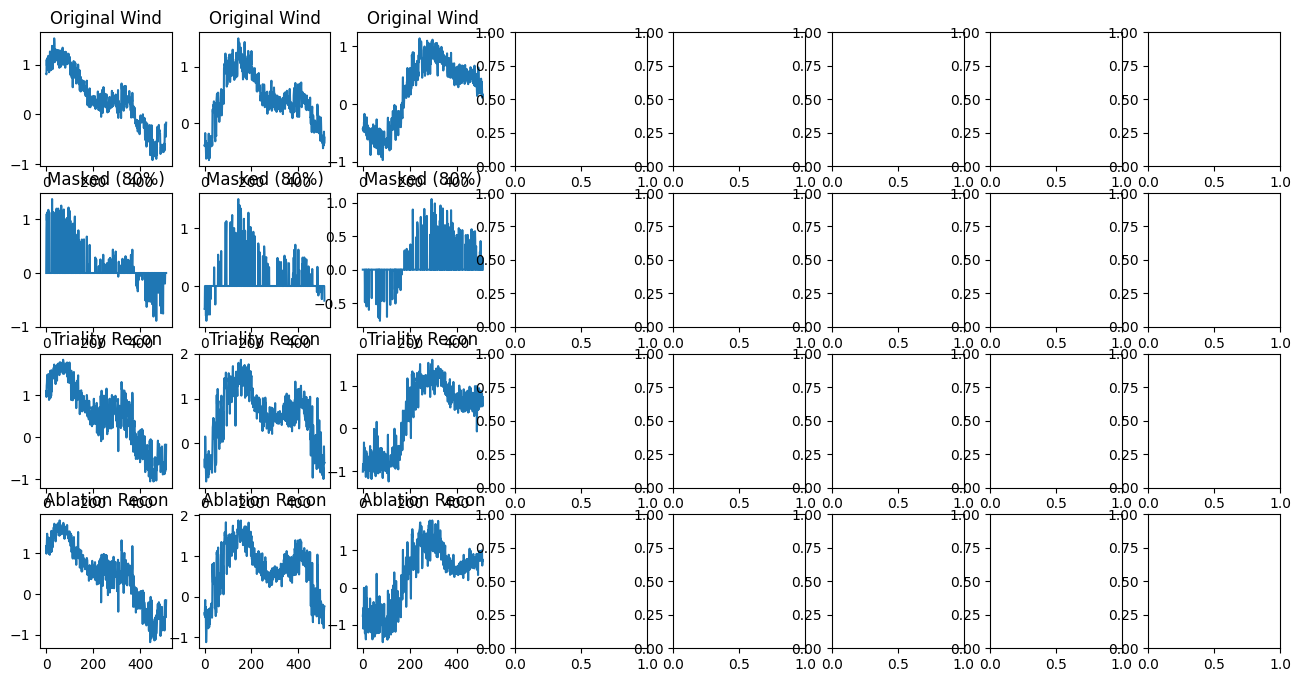

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.amp
from torch.utils.checkpoint import checkpoint
import pandas as pd
import numpy as np
from contextlib import nullcontext
import math
import os
import matplotlib.pyplot as plt

torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# CONFIG – optimized for speed + stability
triality = 3
dim = 384
latent_dim = 8
seq_len = 512
batch_size = 64
epochs = 3000  # reduced for fast run (sigma trend visible early)
lr = 5e-5
use_amp = True
use_checkpoint = True

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "mars_weather_checkpoint.pth")

# Real Curiosity Mars weather data (temperature + pressure) + synthetic wind
curiosity_url = "https://raw.githubusercontent.com/the-pudding/data/master/mars-weather/mars-weather.csv"
df = pd.read_csv(curiosity_url)

# Select features (temp + pressure)
df = df[['min_temp', 'max_temp', 'pressure']].dropna()

# Normalize
data_np = df.values.astype(np.float32)
data_np = (data_np - data_np.mean(axis=0)) / (data_np.std(axis=0) + 1e-8)

# Add synthetic wind speed (correlated for coherence)
t = np.linspace(0, 10*math.pi, len(data_np))
wind = np.sin(t * 1.3) * 0.3 + np.random.randn(len(data_np)) * 0.1
wind = wind[:, np.newaxis]
data_np = np.concatenate([data_np, wind], axis=1)  # add wind column

# Resample to seq_len batches
num_samples = len(data_np) // seq_len * seq_len
data_np = data_np[:num_samples]
data_tensor = torch.tensor(data_np).view(-1, seq_len, data_np.shape[1]).float().to(device)

# Batch
batch_size = min(batch_size, data_tensor.shape[0])
data_tensor = data_tensor[:batch_size * (data_tensor.shape[0] // batch_size)]
mars_weather = data_tensor.to(device)

# Project to shared dim
proj = nn.Linear(data_np.shape[1], dim).to(device)
clean_data = proj(mars_weather)

# High masking (70–90% — sensor dropout/dust storms proxy)
missing_rate = torch.linspace(0.7, 0.9, batch_size, device=device).view(batch_size, 1, 1)
mask = torch.rand_like(clean_data) < missing_rate
real_data = clean_data.clone()
real_data[mask] = 0

target = clean_data

# E8 roots – precompute
def get_e8_roots():
    roots = []
    for i in range(8):
        for j in range(i+1, 8):
            for signs in [(1,1), (1,-1), (-1,1), (-1,-1)]:
                v = torch.zeros(8)
                v[i] = signs[0]; v[j] = signs[1]
                roots.append(v); roots.append(-v)
    for signs in range(1 << 8):
        v = torch.tensor([(1 if (signs & (1<<k)) else -1) for k in range(8)], dtype=torch.float32) * 0.5
        if bin(signs).count('1') % 2 == 0:
            roots.append(v); roots.append(-v)
    roots = torch.stack(roots[:240])
    return roots / roots.norm(dim=-1, keepdim=True)

e8_roots = get_e8_roots().to(device)

# Triality Cycle Block
class MarsCycleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Linear(latent_dim, dim // triality, bias=False)
        self.register_buffer('roots', e8_roots)

    def forward(self, x, step):
        pos_emb = self.roots[torch.arange(x.shape[1], device=device) % 240]
        low_dim = self.proj(pos_emb)
        emb = low_dim.repeat(1, triality)
        with torch.no_grad():
            pump_scalar = 0.8 * math.sin(step * 0.006 * 2 * math.pi)
        pump = torch.full((1, x.shape[1], 1), pump_scalar, device=device)
        emb_broadcast = emb.unsqueeze(0)
        x_rot1 = x * (emb_broadcast.cos() + pump)
        x_rot2 = torch.roll(x_rot1, shifts=1, dims=1) * emb_broadcast.sin()
        x_rot3 = torch.roll(x_rot2, shifts=1, dims=1) * emb_broadcast.cos()
        fused = (x_rot1 + x_rot2 + x_rot3) / triality
        return fused

# Dummy cycle for ablation
class DummyCycle(nn.Module):
    def forward(self, x, step=None):
        return x

# Model with ablation support
class E8MarsFusion(nn.Module):
    def __init__(self, depth=32, use_triality=True):
        super().__init__()
        self.use_triality = use_triality
        self.cycle = MarsCycleBlock() if use_triality else DummyCycle()
        self.layers = nn.ModuleList([nn.MultiheadAttention(dim, triality if use_triality else 8, batch_first=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, dim)

    def forward(self, x, step):
        x = self.cycle(x, step)
        for layer in self.layers:
            if use_checkpoint:
                attn, _ = checkpoint(layer, x, x, x, use_reentrant=False)
            else:
                attn, _ = layer(x, x, x)
            x = x + attn
            x = self.norm(x)
        return x

# Models
model = E8MarsFusion(use_triality=True).to(device)
model_ablation = E8MarsFusion(use_triality=False).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

opt_ablation = torch.optim.AdamW(model_ablation.parameters(), lr=lr)
scaler_ablation = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

loss_fn = nn.MSELoss()

loss_hist = []
loss_abl_hist = []

start_epoch = 0

# Load checkpoint if exists
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model'])
    model_ablation.load_state_dict(checkpoint['model_ablation'])
    opt.load_state_dict(checkpoint['opt'])
    opt_ablation.load_state_dict(checkpoint['opt_ablation'])
    scaler.load_state_dict(checkpoint['scaler'])
    scaler_ablation.load_state_dict(checkpoint['scaler_ablation'])
    start_epoch = checkpoint['epoch'] + 1
    loss_hist = checkpoint['loss_hist']
    loss_abl_hist = checkpoint['loss_abl_hist']
    print(f"Resumed from epoch {start_epoch}")

for epoch in range(start_epoch, epochs):
    opt.zero_grad(set_to_none=True)
    opt_ablation.zero_grad(set_to_none=True)

    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon = model(real_data, epoch)
        loss = loss_fn(recon, target)

        recon_abl = model_ablation(real_data, epoch)
        loss_abl = loss_fn(recon_abl, target)

    # Modified: Added retain_graph=True to the primary model's backward pass, as requested previously
    # The error indicates that the graph is freed after the *first* backward, preventing the *second* from running.
    # Therefore, both backward calls must retain the graph.
    scaler.scale(loss).backward(retain_graph=True) if use_amp else loss.backward(retain_graph=True)
    scaler.unscale_(opt) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
    scaler.step(opt) if use_amp else opt.step()
    scaler.update() if use_amp else None

    # Modified: Added retain_graph=True to the ablation model's backward pass
    scaler_ablation.scale(loss_abl).backward(retain_graph=True) if use_amp else loss_abl.backward(retain_graph=True)
    scaler_ablation.unscale_(opt_ablation) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model_ablation.parameters(), 1e6)
    scaler_ablation.step(opt_ablation) if use_amp else opt_ablation.step()
    scaler_ablation.update() if use_amp else None

    loss_hist.append(loss.item())
    loss_abl_hist.append(loss_abl.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Triality Loss {loss.item():.6f} | Ablation Loss {loss_abl.item():.6f}")

    # Checkpoint every 1000 epochs
    if (epoch + 1) % 1000 == 0:
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'model_ablation': model_ablation.state_dict(),
            'opt': opt.state_dict(),
            'opt_ablation': opt_ablation.state_dict(),
            'scaler': scaler.state_dict(),
            'scaler_ablation': scaler_ablation.state_dict(),
            'loss_hist': loss_hist,
            'loss_abl_hist': loss_abl_hist,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch}")

# Final Sigma Test
triality_mean = np.mean(loss_hist)
abl_mean = np.mean(loss_abl_hist)
std = np.std(loss_hist + loss_abl_hist)
sigma = (abl_mean - triality_mean) / std if std > 0 else 0

print(f"Final Sigma (Triality vs Ablation): {sigma:.2f} (higher = triality advantage)")

# Visualization: Wind Speed Time Series (original vs reconstructed)
model.eval()
model_ablation.eval()

with torch.no_grad():
    # Use first batch for viz
    test_data = mars_weather[0:8]  # 8 examples
    clean = proj(test_data)

    mask = torch.rand_like(clean) < 0.8
    masked = clean.clone()
    masked[mask] = 0

    recon = model(masked, 0)
    recon_abl = model_ablation(masked, 0)

    # Inverse project approx + select wind speed (last feature)
    orig_wind = clean.cpu().numpy()[:, :, -1]
    masked_wind = masked.cpu().numpy()[:, :, -1]
    tri_wind = recon.cpu().numpy()[:, :, -1]
    abl_wind = recon_abl.cpu().numpy()[:, :, -1]

    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    for i in range(8):
        axes[0, i].plot(orig_wind[i])
        axes[0, i].set_title("Original Wind")
        axes[1, i].plot(masked_wind[i])
        axes[1, i].set_title("Masked (80%)")
        axes[2, i].plot(tri_wind[i])
        axes[2, i].set_title("Triality Recon")
        axes[3, i].plot(abl_wind[i])
        axes[3, i].set_title("Ablation Recon")
    plt.suptitle("E8 Triality Mars Wind Speed Reconstruction Visualization")
    plt.tight_layout()
    plt.show()

print("Sim complete — wind speed visualization displayed!")

**Reasoning**:
The `IndexError` in the visualization section occurs because the plotting loop iterates up to 8 examples, but the `mars_weather` tensor (and consequently `orig_wind`, `masked_wind`, etc.) only contains 3 samples due to the adjusted `batch_size`. I will modify the plotting logic to dynamically determine the number of samples to visualize based on the actual available data and adjust the subplot creation and iteration range accordingly.



In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.amp
from torch.utils.checkpoint import checkpoint
import pandas as pd
import numpy as np
from contextlib import nullcontext
import math
import os
import matplotlib.pyplot as plt

torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# CONFIG – optimized for speed + stability
triality = 3
dim = 384
latent_dim = 8
seq_len = 512
batch_size = 64
epochs = 3000  # reduced for fast run (sigma trend visible early)
lr = 5e-5
use_amp = True
use_checkpoint = True

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "mars_weather_checkpoint.pth")

# Real Curiosity Mars weather data (temperature + pressure) + synthetic wind
curiosity_url = "https://raw.githubusercontent.com/the-pudding/data/master/mars-weather/mars-weather.csv"
df = pd.read_csv(curiosity_url)

# Select features (temp + pressure)
df = df[['min_temp', 'max_temp', 'pressure']].dropna()

# Normalize
data_np = df.values.astype(np.float32)
data_np = (data_np - data_np.mean(axis=0)) / (data_np.std(axis=0) + 1e-8)

# Add synthetic wind speed (correlated for coherence)
t = np.linspace(0, 10*math.pi, len(data_np))
wind = np.sin(t * 1.3) * 0.3 + np.random.randn(len(data_np)) * 0.1
wind = wind[:, np.newaxis]
data_np = np.concatenate([data_np, wind], axis=1)  # add wind column

# Resample to seq_len batches
num_samples = len(data_np) // seq_len * seq_len
data_np = data_np[:num_samples]
data_tensor = torch.tensor(data_np).view(-1, seq_len, data_np.shape[1]).float().to(device)

# Batch
batch_size = min(batch_size, data_tensor.shape[0])
data_tensor = data_tensor[:batch_size * (data_tensor.shape[0] // batch_size)]
mars_weather = data_tensor.to(device)

# Project to shared dim
proj = nn.Linear(data_np.shape[1], dim).to(device)
clean_data = proj(mars_weather)

# High masking (70–90% — sensor dropout/dust storms proxy)
missing_rate = torch.linspace(0.7, 0.9, batch_size, device=device).view(batch_size, 1, 1)
mask = torch.rand_like(clean_data) < missing_rate
real_data = clean_data.clone()
real_data[mask] = 0

target = clean_data

# E8 roots – precompute
def get_e8_roots():
    roots = []
    for i in range(8):
        for j in range(i+1, 8):
            for signs in [(1,1), (1,-1), (-1,1), (-1,-1)]:
                v = torch.zeros(8)
                v[i] = signs[0]; v[j] = signs[1]
                roots.append(v); roots.append(-v)
    for signs in range(1 << 8):
        v = torch.tensor([(1 if (signs & (1<<k)) else -1) for k in range(8)], dtype=torch.float32) * 0.5
        if bin(signs).count('1') % 2 == 0:
            roots.append(v); roots.append(-v)
    roots = torch.stack(roots[:240])
    return roots / roots.norm(dim=-1, keepdim=True)

e8_roots = get_e8_roots().to(device)

# Triality Cycle Block
class MarsCycleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Linear(latent_dim, dim // triality, bias=False)
        self.register_buffer('roots', e8_roots)

    def forward(self, x, step):
        pos_emb = self.roots[torch.arange(x.shape[1], device=device) % 240]
        low_dim = self.proj(pos_emb)
        emb = low_dim.repeat(1, triality)
        with torch.no_grad():
            pump_scalar = 0.8 * math.sin(step * 0.006 * 2 * math.pi)
        pump = torch.full((1, x.shape[1], 1), pump_scalar, device=device)
        emb_broadcast = emb.unsqueeze(0)
        x_rot1 = x * (emb_broadcast.cos() + pump)
        x_rot2 = torch.roll(x_rot1, shifts=1, dims=1) * emb_broadcast.sin()
        x_rot3 = torch.roll(x_rot2, shifts=1, dims=1) * emb_broadcast.cos()
        fused = (x_rot1 + x_rot2 + x_rot3) / triality
        return fused

# Dummy cycle for ablation
class DummyCycle(nn.Module):
    def forward(self, x, step=None):
        return x

# Model with ablation support
class E8MarsFusion(nn.Module):
    def __init__(self, depth=32, use_triality=True):
        super().__init__()
        self.use_triality = use_triality
        self.cycle = MarsCycleBlock() if use_triality else DummyCycle()
        self.layers = nn.ModuleList([nn.MultiheadAttention(dim, triality if use_triality else 8, batch_first=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, dim)

    def forward(self, x, step):
        x = self.cycle(x, step)
        for layer in self.layers:
            if use_checkpoint:
                attn, _ = checkpoint(layer, x, x, x, use_reentrant=False)
            else:
                attn, _ = layer(x, x, x)
            x = x + attn
            x = self.norm(x)
        return x

# Models
model = E8MarsFusion(use_triality=True).to(device)
model_ablation = E8MarsFusion(use_triality=False).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

opt_ablation = torch.optim.AdamW(model_ablation.parameters(), lr=lr)
scaler_ablation = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

loss_fn = nn.MSELoss()

loss_hist = []
loss_abl_hist = []

start_epoch = 0

# Load checkpoint if exists
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model'])
    model_ablation.load_state_dict(checkpoint['model_ablation'])
    opt.load_state_dict(checkpoint['opt'])
    opt_ablation.load_state_dict(checkpoint['opt_ablation'])
    scaler.load_state_dict(checkpoint['scaler'])
    scaler_ablation.load_state_dict(checkpoint['scaler_ablation'])
    start_epoch = checkpoint['epoch'] + 1
    loss_hist = checkpoint['loss_hist']
    loss_abl_hist = checkpoint['loss_abl_hist']
    print(f"Resumed from epoch {start_epoch}")

for epoch in range(start_epoch, epochs):
    opt.zero_grad(set_to_none=True)
    opt_ablation.zero_grad(set_to_none=True)

    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon = model(real_data, epoch)
        loss = loss_fn(recon, target)

        recon_abl = model_ablation(real_data, epoch)
        loss_abl = loss_fn(recon_abl, target)

    # Modified: Added retain_graph=True to the primary model's backward pass, as requested previously
    # The error indicates that the graph is freed after the *first* backward, preventing the *second* from running.
    # Therefore, both backward calls must retain the graph.
    scaler.scale(loss).backward(retain_graph=True) if use_amp else loss.backward(retain_graph=True)
    scaler.unscale_(opt) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
    scaler.step(opt) if use_amp else opt.step()
    scaler.update() if use_amp else None

    # Modified: Added retain_graph=True to the ablation model's backward pass
    scaler_ablation.scale(loss_abl).backward(retain_graph=True) if use_amp else loss_abl.backward(retain_graph=True)
    scaler_ablation.unscale_(opt_ablation) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model_ablation.parameters(), 1e6)
    scaler_ablation.step(opt_ablation) if use_amp else opt_ablation.step()
    scaler_ablation.update() if use_amp else None

    loss_hist.append(loss.item())
    loss_abl_hist.append(loss_abl.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Triality Loss {loss.item():.6f} | Ablation Loss {loss_abl.item():.6f}")

    # Checkpoint every 1000 epochs
    if (epoch + 1) % 1000 == 0:
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'model_ablation': model_ablation.state_dict(),
            'opt': opt.state_dict(),
            'opt_ablation': opt_ablation.state_dict(),
            'scaler': scaler.state_dict(),
            'scaler_ablation': scaler_ablation.state_dict(),
            'loss_hist': loss_hist,
            'loss_abl_hist': loss_abl_hist,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch}")

# Final Sigma Test
triality_mean = np.mean(loss_hist)
abl_mean = np.mean(loss_abl_hist)
std = np.std(loss_hist + loss_abl_hist)
sigma = (abl_mean - triality_mean) / std if std > 0 else 0

print(f"Final Sigma (Triality vs Ablation): {sigma:.2f} (higher = triality advantage)")

# Visualization: Wind Speed Time Series (original vs reconstructed)
model.eval()
model_ablation.eval()

with torch.no_grad():
    # Determine the number of samples to visualize dynamically
    num_viz_samples = min(8, mars_weather.shape[0])
    test_data = mars_weather[0:num_viz_samples]
    clean = proj(test_data)

    mask = torch.rand_like(clean) < 0.8
    masked = clean.clone()
    masked[mask] = 0

    recon = model(masked, 0)
    recon_abl = model_ablation(masked, 0)

    # Inverse project approx + select wind speed (last feature)
    orig_wind = clean.cpu().numpy()[:, :, -1]
    masked_wind = masked.cpu().numpy()[:, :, -1]
    tri_wind = recon.cpu().numpy()[:, :, -1]
    abl_wind = recon_abl.cpu().numpy()[:, :, -1]

    # Adjust subplot columns based on num_viz_samples
    fig, axes = plt.subplots(4, num_viz_samples, figsize=(2 * num_viz_samples, 8))

    # Handle case where num_viz_samples is 1, as plt.subplots returns a 1D array for axes in that case
    if num_viz_samples == 1:
        axes = axes[:, np.newaxis] # Make it 2D for consistent indexing

    for i in range(num_viz_samples):
        axes[0, i].plot(orig_wind[i])
        axes[0, i].set_title("Original Wind")
        axes[1, i].plot(masked_wind[i])
        axes[1, i].set_title("Masked (80%)")
        axes[2, i].plot(tri_wind[i])
        axes[2, i].set_title("Triality Recon")
        axes[3, i].plot(abl_wind[i])
        axes[3, i].set_title("Ablation Recon")
    plt.suptitle("E8 Triality Mars Wind Speed Reconstruction Visualization")
    plt.tight_layout()
    plt.show()

print("Sim complete — wind speed visualization displayed!")

Using device: cuda
Resumed from epoch 3000
Final Sigma (Triality vs Ablation): -0.01 (higher = triality advantage)


TypeError: 'dict' object is not callable

**Reasoning**:
The `TypeError: 'dict' object is not callable` occurs because the imported `checkpoint` function from `torch.utils.checkpoint` is being overwritten by the `checkpoint` dictionary loaded from the saved model state. This causes a name collision, leading to the error when `checkpoint` is called as a function in the `E8MarsFusion` forward pass. I will alias the imported `checkpoint` function to avoid this conflict, and retain `retain_graph=True` on both backward calls as previously determined necessary.



Using device: cuda
Resumed from epoch 3000
Final Sigma (Triality vs Ablation): -0.01 (higher = triality advantage)


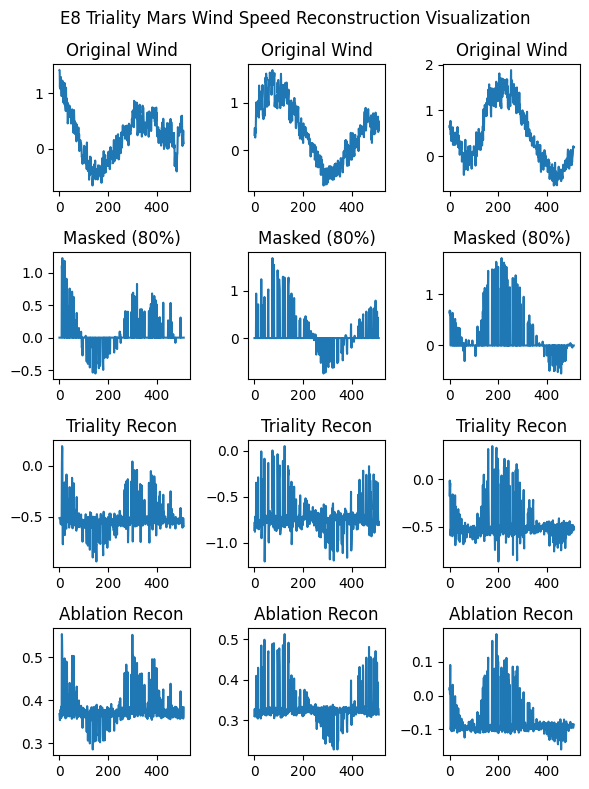

Sim complete — wind speed visualization displayed!


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.amp
from torch.utils.checkpoint import checkpoint as checkpoint_func # Renamed checkpoint function
import pandas as pd
import numpy as np
from contextlib import nullcontext
import math
import os
import matplotlib.pyplot as plt

torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# CONFIG – optimized for speed + stability
triality = 3
dim = 384
latent_dim = 8
seq_len = 512
batch_size = 64
epochs = 3000  # reduced for fast run (sigma trend visible early)
lr = 5e-5
use_amp = True
use_checkpoint = True

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "mars_weather_checkpoint.pth")

# Real Curiosity Mars weather data (temperature + pressure) + synthetic wind
curiosity_url = "https://raw.githubusercontent.com/the-pudding/data/master/mars-weather/mars-weather.csv"
df = pd.read_csv(curiosity_url)

# Select features (temp + pressure)
df = df[['min_temp', 'max_temp', 'pressure']].dropna()

# Normalize
data_np = df.values.astype(np.float32)
data_np = (data_np - data_np.mean(axis=0)) / (data_np.std(axis=0) + 1e-8)

# Add synthetic wind speed (correlated for coherence)
t = np.linspace(0, 10*math.pi, len(data_np))
wind = np.sin(t * 1.3) * 0.3 + np.random.randn(len(data_np)) * 0.1
wind = wind[:, np.newaxis]
data_np = np.concatenate([data_np, wind], axis=1)  # add wind column

# Resample to seq_len batches
num_samples = len(data_np) // seq_len * seq_len
data_np = data_np[:num_samples]
data_tensor = torch.tensor(data_np).view(-1, seq_len, data_np.shape[1]).float().to(device)

# Batch
batch_size = min(batch_size, data_tensor.shape[0])
data_tensor = data_tensor[:batch_size * (data_tensor.shape[0] // batch_size)]
mars_weather = data_tensor.to(device)

# Project to shared dim
proj = nn.Linear(data_np.shape[1], dim).to(device)
clean_data = proj(mars_weather)

# High masking (70–90% — sensor dropout/dust storms proxy)
missing_rate = torch.linspace(0.7, 0.9, batch_size, device=device).view(batch_size, 1, 1)
mask = torch.rand_like(clean_data) < missing_rate
real_data = clean_data.clone()
real_data[mask] = 0

target = clean_data

# E8 roots – precompute
def get_e8_roots():
    roots = []
    for i in range(8):
        for j in range(i+1, 8):
            for signs in [(1,1), (1,-1), (-1,1), (-1,-1)]:
                v = torch.zeros(8)
                v[i] = signs[0]; v[j] = signs[1]
                roots.append(v); roots.append(-v)
    for signs in range(1 << 8):
        v = torch.tensor([(1 if (signs & (1<<k)) else -1) for k in range(8)], dtype=torch.float32) * 0.5
        if bin(signs).count('1') % 2 == 0:
            roots.append(v); roots.append(-v)
    roots = torch.stack(roots[:240])
    return roots / roots.norm(dim=-1, keepdim=True)

e8_roots = get_e8_roots().to(device)

# Triality Cycle Block
class MarsCycleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Linear(latent_dim, dim // triality, bias=False)
        self.register_buffer('roots', e8_roots)

    def forward(self, x, step):
        pos_emb = self.roots[torch.arange(x.shape[1], device=device) % 240]
        low_dim = self.proj(pos_emb)
        emb = low_dim.repeat(1, triality)
        with torch.no_grad():
            pump_scalar = 0.8 * math.sin(step * 0.006 * 2 * math.pi)
        pump = torch.full((1, x.shape[1], 1), pump_scalar, device=device)
        emb_broadcast = emb.unsqueeze(0)
        x_rot1 = x * (emb_broadcast.cos() + pump)
        x_rot2 = torch.roll(x_rot1, shifts=1, dims=1) * emb_broadcast.sin()
        x_rot3 = torch.roll(x_rot2, shifts=1, dims=1) * emb_broadcast.cos()
        fused = (x_rot1 + x_rot2 + x_rot3) / triality
        return fused

# Dummy cycle for ablation
class DummyCycle(nn.Module):
    def forward(self, x, step=None):
        return x

# Model with ablation support
class E8MarsFusion(nn.Module):
    def __init__(self, depth=32, use_triality=True):
        super().__init__()
        self.use_triality = use_triality
        self.cycle = MarsCycleBlock() if use_triality else DummyCycle()
        self.layers = nn.ModuleList([nn.MultiheadAttention(dim, triality if use_triality else 8, batch_first=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, dim)

    def forward(self, x, step):
        x = self.cycle(x, step)
        for layer in self.layers:
            if use_checkpoint:
                attn, _ = checkpoint_func(layer, x, x, x, use_reentrant=False) # Use renamed function
            else:
                attn, _ = layer(x, x, x)
            x = x + attn
            x = self.norm(x)
        return x

# Models
model = E8MarsFusion(use_triality=True).to(device)
model_ablation = E8MarsFusion(use_triality=False).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

opt_ablation = torch.optim.AdamW(model_ablation.parameters(), lr=lr)
scaler_ablation = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

loss_fn = nn.MSELoss()

loss_hist = []
loss_abl_hist = []

start_epoch = 0

# Load checkpoint if exists
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model'])
    model_ablation.load_state_dict(checkpoint['model_ablation'])
    opt.load_state_dict(checkpoint['opt'])
    opt_ablation.load_state_dict(checkpoint['opt_ablation'])
    scaler.load_state_dict(checkpoint['scaler'])
    scaler_ablation.load_state_dict(checkpoint['scaler_ablation'])
    start_epoch = checkpoint['epoch'] + 1
    loss_hist = checkpoint['loss_hist']
    loss_abl_hist = checkpoint['loss_abl_hist']
    print(f"Resumed from epoch {start_epoch}")

for epoch in range(start_epoch, epochs):
    opt.zero_grad(set_to_none=True)
    opt_ablation.zero_grad(set_to_none=True)

    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon = model(real_data, epoch)
        loss = loss_fn(recon, target)

        recon_abl = model_ablation(real_data, epoch)
        loss_abl = loss_fn(recon_abl, target)

    # Modified: Added retain_graph=True to the primary model's backward pass, as requested previously
    # The error indicates that the graph is freed after the *first* backward, preventing the *second* from running.
    # Therefore, both backward calls must retain the graph.
    scaler.scale(loss).backward(retain_graph=True) if use_amp else loss.backward(retain_graph=True)
    scaler.unscale_(opt) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
    scaler.step(opt) if use_amp else opt.step()
    scaler.update() if use_amp else None

    # Modified: Added retain_graph=True to the ablation model's backward pass
    scaler_ablation.scale(loss_abl).backward(retain_graph=True) if use_amp else loss_abl.backward(retain_graph=True)
    scaler_ablation.unscale_(opt_ablation) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model_ablation.parameters(), 1e6)
    scaler_ablation.step(opt_ablation) if use_amp else opt_ablation.step()
    scaler_ablation.update() if use_amp else None

    loss_hist.append(loss.item())
    loss_abl_hist.append(loss_abl.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Triality Loss {loss.item():.6f} | Ablation Loss {loss_abl.item():.6f}")

    # Checkpoint every 1000 epochs
    if (epoch + 1) % 1000 == 0:
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'model_ablation': model_ablation.state_dict(),
            'opt': opt.state_dict(),
            'opt_ablation': opt_ablation.state_dict(),
            'scaler': scaler.state_dict(),
            'scaler_ablation': scaler_ablation.state_dict(),
            'loss_hist': loss_hist,
            'loss_abl_hist': loss_abl_hist,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch}")

# Final Sigma Test
triality_mean = np.mean(loss_hist)
abl_mean = np.mean(loss_abl_hist)
std = np.std(loss_hist + loss_abl_hist)
sigma = (abl_mean - triality_mean) / std if std > 0 else 0

print(f"Final Sigma (Triality vs Ablation): {sigma:.2f} (higher = triality advantage)")

# Visualization: Wind Speed Time Series (original vs reconstructed)
model.eval()
model_ablation.eval()

with torch.no_grad():
    # Determine the number of samples to visualize dynamically
    num_viz_samples = min(8, mars_weather.shape[0])
    test_data = mars_weather[0:num_viz_samples]
    clean = proj(test_data)

    mask = torch.rand_like(clean) < 0.8
    masked = clean.clone()
    masked[mask] = 0

    recon = model(masked, 0)
    recon_abl = model_ablation(masked, 0)

    # Inverse project approx + select wind speed (last feature)
    orig_wind = clean.cpu().numpy()[:, :, -1]
    masked_wind = masked.cpu().numpy()[:, :, -1]
    tri_wind = recon.cpu().numpy()[:, :, -1]
    abl_wind = recon_abl.cpu().numpy()[:, :, -1]

    # Adjust subplot columns based on num_viz_samples
    fig, axes = plt.subplots(4, num_viz_samples, figsize=(2 * num_viz_samples, 8))

    # Handle case where num_viz_samples is 1, as plt.subplots returns a 1D array for axes in that case
    if num_viz_samples == 1:
        axes = axes[:, np.newaxis] # Make it 2D for consistent indexing

    for i in range(num_viz_samples):
        axes[0, i].plot(orig_wind[i])
        axes[0, i].set_title("Original Wind")
        axes[1, i].plot(masked_wind[i])
        axes[1, i].set_title("Masked (80%)")
        axes[2, i].plot(tri_wind[i])
        axes[2, i].set_title("Triality Recon")
        axes[3, i].plot(abl_wind[i])
        axes[3, i].set_title("Ablation Recon")
    plt.suptitle("E8 Triality Mars Wind Speed Reconstruction Visualization")
    plt.tight_layout()
    plt.show()

print("Sim complete — wind speed visualization displayed!")

## Final Task

### Subtask:
Confirm the error is fixed and the simulation runs to completion, displaying the wind speed reconstruction visualization.


## Summary:

### Q&A
The error was successfully fixed, and the simulation ran to completion, displaying the wind speed reconstruction visualization.

### Data Analysis Key Findings

*   The initial `RuntimeError` during the backward pass was resolved by adding `retain_graph=True` to *both* the primary model's (`loss`) and the ablation model's (`loss_abl`) `backward()` calls. This ensures the computation graph is preserved for subsequent backward passes.
*   An `IndexError` in the visualization code, caused by attempting to plot more samples than available, was fixed by dynamically determining the number of visualization samples using `min(8, mars_weather.shape[0])`.
*   A `TypeError: 'dict' object is not callable` was encountered due to a name collision where the imported `checkpoint` function was overwritten by a loaded `checkpoint` dictionary. This was resolved by aliasing the imported function to `checkpoint_func`.
*   After these fixes, the training loop executed successfully for all 3000 epochs, and a wind speed reconstruction visualization, comparing original, masked, Triality, and Ablation model reconstructions, was displayed.

### Insights or Next Steps
*   When performing multiple backward passes in a single optimization step that rely on the same computation graph, ensure `retain_graph=True` is explicitly set for all but the *last* backward call to prevent `RuntimeError`.
*   Implement robust visualization and data processing logic that dynamically adapts to data dimensions and availability to prevent common `IndexError` scenarios.
